In [1]:
%load_ext autoreload
%autoreload 2
import importlib.util
import sys
import os

# print(os.getcwd())
# loc = '/afs/ciemat.es/user/m/martialc/public/muTel/src/muTel/__init__.py'
loc = '/home/nfs/user/martialc/muTel_work/muTel_v02/muTel/src/muTel/__init__.py'
# loc = '../../src/muTel/__init__.py'
src = 'muTel'
spec = importlib.util.spec_from_file_location(src, loc)
foo = importlib.util.module_from_spec(spec)
sys.modules["muTel"] = foo
spec.loader.exec_module(foo)

In [2]:
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import pickle
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from IPython.display import HTML
import time
import json
import os
import lmfit
from lmfit.models import GaussianModel, SineModel
from scipy.fft import fft,fftfreq, fftshift, ifft
from scipy.signal import butter,filtfilt, resample
from scipy.stats import linregress, chisquare, gaussian_kde

In [3]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['figure.dpi'] = 140
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (12, 5) 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:cerulean blue', 'xkcd:pale orange', 'xkcd:sage green', 'xkcd:dull purple', 'xkcd:terra cotta', 'xkcd:teal', 'xkcd:pale red', 'xkcd:cadet blue', 'xkcd: goldenrod',
'xkcd:scarlet']

In [4]:
from muTel.dqm.classes.MuData import MuData, MuSL
from muTel.dqm.classes.MuTel import MuTel
from muTel.utils.meta import *

from muTel.utils.fitting import f_track

In [ ]:
tel = MuTel(MuData.from_run(588))

In [ ]:
fits = tel.fit_traces()

In [6]:
with open('/home/nfs/user/martialc/muTel_work/muTel_v02/muTel/dev/dqm/models/fitted.sl','rb') as file:
    sl = pickle.load(file)
# df = sl[1].df

## Timebox

In [7]:
T0_fit, Tmax_fit = sl[1].set_timebox()

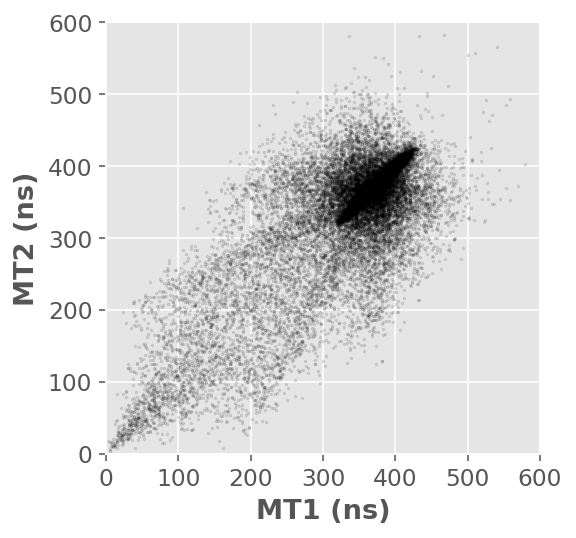

MT1:	370.93 +- 27.56 ns
MT2:	370.76 +- 27.56 ns


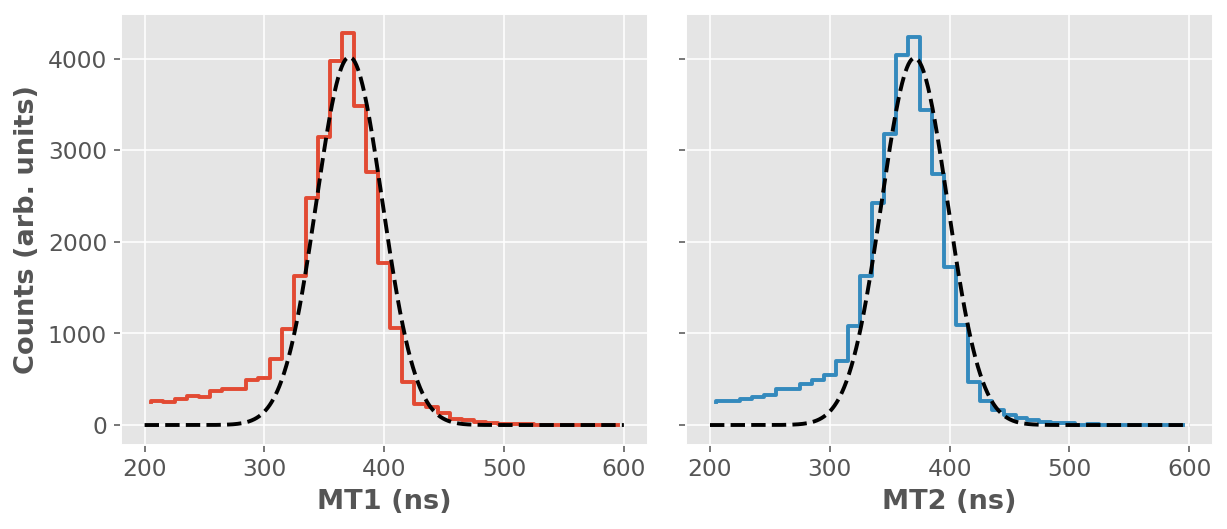

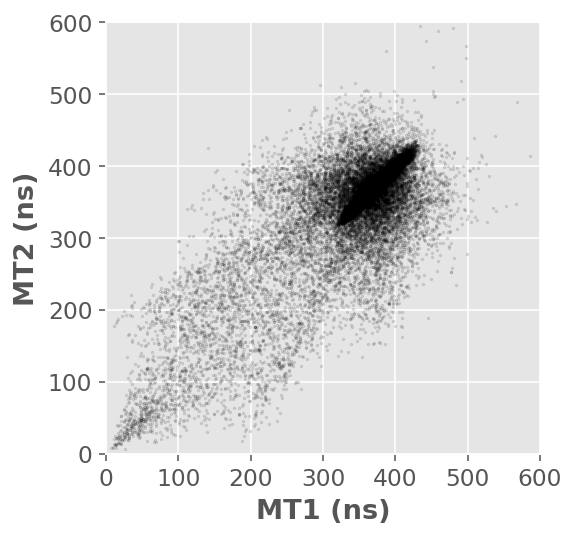

MT1:	371.73 +- 27.61 ns
MT2:	370.42 +- 27.86 ns


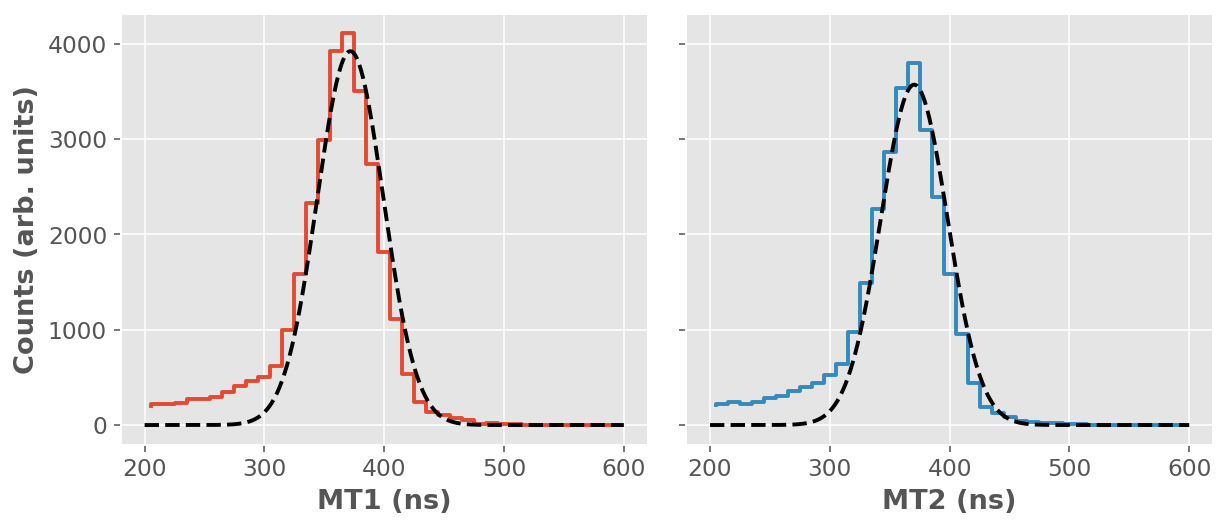

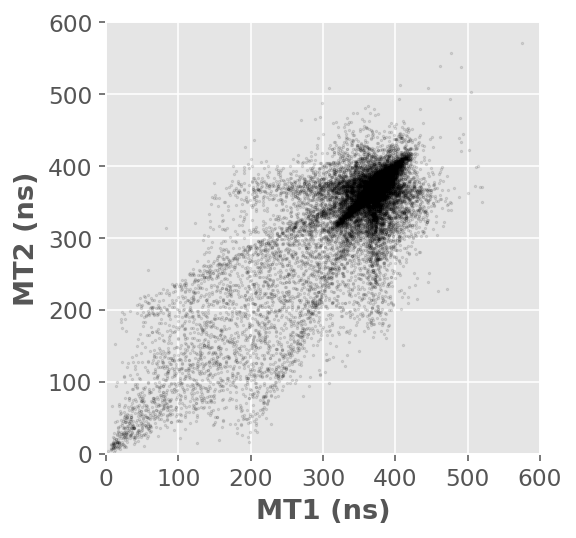

MT1:	371.45 +- 11.89 ns
MT2:	369.80 +- 11.12 ns


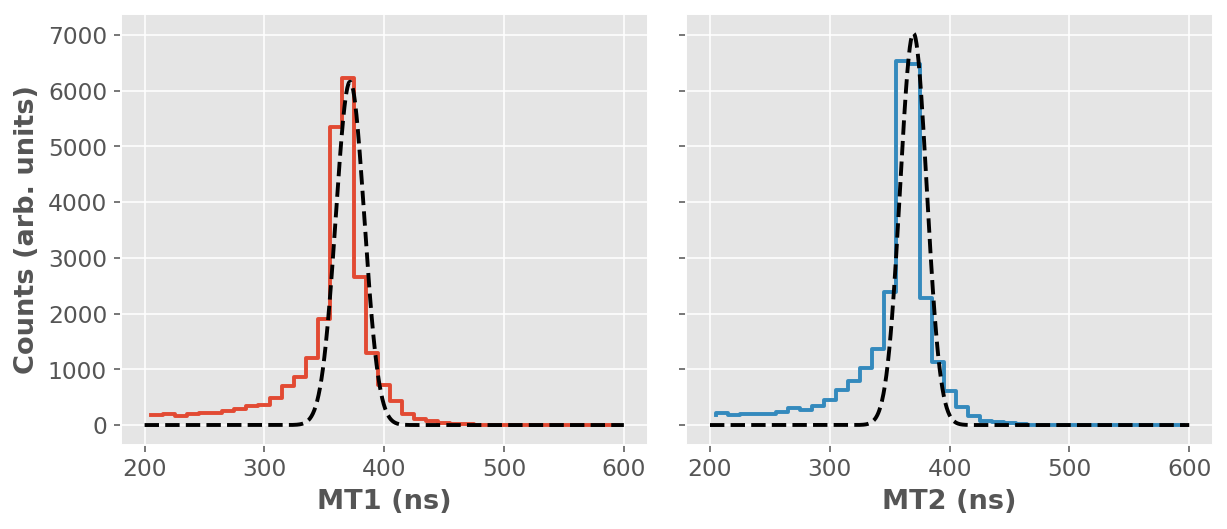

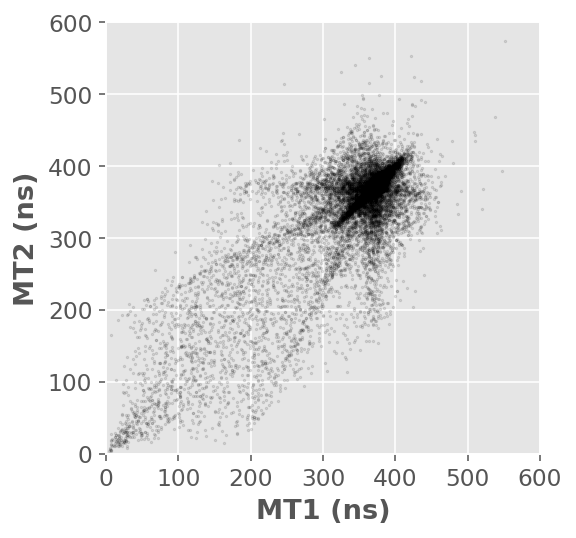

MT1:	369.80 +- 11.20 ns
MT2:	369.98 +- 10.88 ns


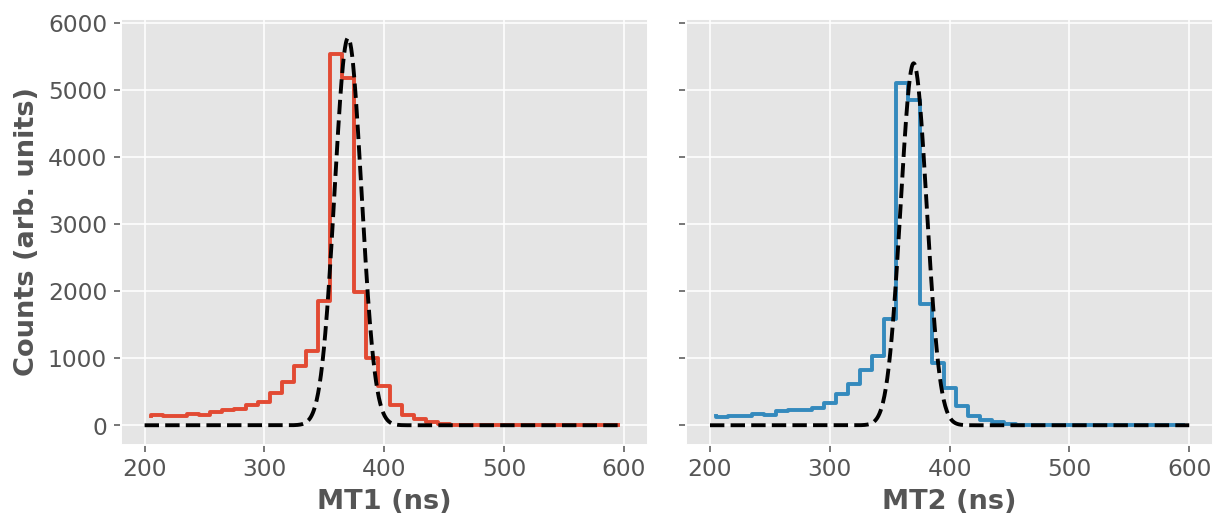

In [8]:
hist_range = (200,600)
scat_range = (0,600)
nbins = 40


plot_mids = np.linspace(*hist_range,1001)

for sl_i in [1,2,3,4]:
    fig_mt2d,ax = plt.subplots(1,1,figsize=(4,4))

    dts = (sl[sl_i].drifttimes - sl[sl_i].T0)
    cut = (0< dts).all(axis=1) & (dts < sl[sl_i].Tmax - sl[sl_i].T0).all(axis=1)
    
    mt1 = (dts.t1 + dts.t3)/2 + dts.t2
    mt2 = (dts.t2 + dts.t4)/2 + dts.t3

    plt.scatter(mt1, mt2,alpha=0.1,color=f'k',s=1.5,rasterized=True)

    plt.xlabel('MT1 (ns)',fontsize=14)
    plt.ylabel('MT2 (ns)',fontsize=14)



    plt.xlim(*scat_range)
    plt.ylim(*scat_range)
    plt.savefig(f'/home/nfs/user/martialc/muTel_work/muTel_v02/muTel/dev/figs/mts_2d_sl{sl_i}.svg',transparent=False)
    plt.show()
    # del fig
    time.sleep(1)
    fig_mt1d,axes = plt.subplots(1,2,figsize=(9,4),sharex=True,sharey=True)
    for i, mt in enumerate([mt1,mt2]):
        ax = axes.ravel()[i]
        cts, edges = np.histogram(mt,range = hist_range,bins = nbins)
        mids = (edges[1:] + edges[:-1])/2

        model = GaussianModel()
        pars = model.guess(cts,x=mids)
        fit = model.fit(cts,pars,x=mids)
        print(f'MT{i+1}:\t{fit.params["center"].value:.2f} +- {fit.params["sigma"].value:.2f} ns')
        ax.step(mids,cts,color=f'C{i}')
        ax.plot(plot_mids,fit.eval(x=plot_mids),color='k',linewidth=2,linestyle='dashed')
        ax.set_xlabel(f'MT{i+1} (ns)',fontsize=14)
    axes.ravel()[0].set_ylabel('Counts (arb. units)', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'/home/nfs/user/martialc/muTel_work/muTel_v02/muTel/dev/figs/mts_1d_sl{sl_i}.svg',transparent=False)
    plt.show()
    

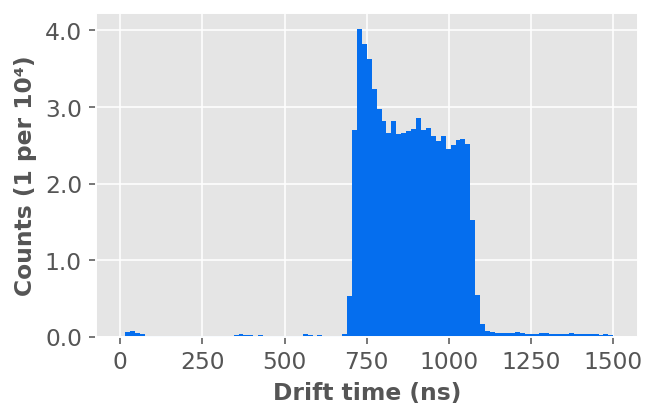

In [9]:
tbox_range = (0,1500)
tbox_bins = 100
plt.figure(figsize=(5,3))

tbox_cts, tbox_edges = np.histogram(sl[1].df.DriftTime,bins=tbox_bins,range=tbox_range)
tbox_mids = (tbox_edges[1:]+tbox_edges[:-1])/2

tbox_width = np.diff(tbox_range[::-1])/tbox_bins

plt.hist(sl[1].df.DriftTime,bins=tbox_bins,range=tbox_range,color='xkcd:cerulean blue',histtype='stepfilled')




tbox_yticks = plt.gca().get_yticks()
_ = plt.gca().yaxis.set_major_formatter(lambda x,pos: f'{x/1e4:.1f}')

plt.ylabel(r'Counts (1 per 10⁴)')
plt.xlabel(r'Drift time (ns)')

# /home/nfs/user/martialc/muTel_work/muTel_v02/muTel/dev/dqm/figs

plt.savefig('/home/nfs/user/martialc/muTel_work/muTel_v02/muTel/dev/figs/timebox.svg',transparent=False)



In [ ]:
for sl_i in [1,2,3,4]:
    print(f'SL{sl_i}: {sl[sl_i].vdrift*1e3:.1f}+-{sl[sl_i].dvdrift*1e3:.1f}')


## Eficiencias (bien) 3/4

In [ ]:
def pos(ser):
    coef = lat_dict[ser['latID'].replace('X','R')]
    pos = layer_offset + cell_width*(ser['ref_cell'] + ser['rel_cells']) + coef*(ser[['t4','t3','t2','t1']]- ser['T0'])*ser['vdrift']

    mis_cell = int(ser.mis_cell)
    if mis_cell != 0:
        pos[-mis_cell] = f_track(wire_height[-mis_cell],ser.theta,ser.x0)
    return pd.Series([*pos],index=['x4','x3','x2','x1'])


In [ ]:
def plot_eff(eff,axes):

    for i,layer in enumerate(layers):

        major_ticks_i = np.r_[0.5*cell_width * (layer % 2),wire_pos[-layer,:]+0.5*cell_width]


        ax_i = axes.ravel()[-layer]
        eff_layer = eff[eff.layer == layer]['eff']

        # ax_i.step(mids,eff_layer,label=f'layer {layer}',color = 'xkcd:cerulean blue')
        ax_i.plot(mids,eff_layer,'x',markersize=1,label=f'layer {layer}',color = 'xkcd:cerulean blue')
        
        
        
        
        # ax_i.set_ylabel('Efficiency',fontsize=14)
        ax_i.tick_params(axis="y",direction="in",which='both')
        ax_i.set_xticks(major_ticks_i)
        ax_i.grid(True,which='major', axis='both')
        ax_i.tick_params(axis="x",direction="in",which='minor',length=0)
        ax_it = ax_i.secondary_xaxis('top')
        ax_ib = ax_i.secondary_xaxis('bottom')

        for ax in [ax_it,ax_ib]:
            ax.tick_params(axis="x",direction="in",which='major',length=5,)
            ax.tick_params(axis="x",direction="in",which='minor',length=3)
            ax.set_xticks(major_ticks_i)
            ax.set_xticks(wire_pos[-layer,:],minor=True)
            
        plt.setp(ax_it.get_xticklabels(), visible=False)
        plt.setp(ax_i.get_xticklabels(), visible=False)
        if layer == 1:
            ax_i.set_xlabel('Position, x (mm)',fontsize=14,labelpad=20)
            plt.setp(ax_ib.get_xticklabels(), visible=True)
        else:
            plt.setp(ax_ib.get_xticklabels(), visible=False)
            
        ax_j = ax_i.twinx()
        # if layer == 1:
        #     ax_i.set_xlabel('Position, x (mm)',fontsize=14)
        #     ax_j.get_xaxis().set_ticks(major_ticks_i)
        #     ax_j.tick_params(axis="both",which='both',length=0)
        # else:
        #     ax_j.get_xaxis().set_ticks([])
        
        ax_j.get_yaxis().set_ticks([])
        ax_j.set_xticks(major_ticks_i)
        ax_j.tick_params(axis="x",direction="in",which='both',length=0)
        ax_j.grid(True,which='major', axis='both')
        ax_j.set_ylabel(f'Layer {layer}',fontsize=10,labelpad=5)


        ax_i.set_xlim(- 0.5, ncells*cell_width + 0.5)
        ax_i.set_ylim(0.45, 1.05)
    # plt.legend()
    ax_i.get_figure().text(0.07, 0.5, 'Efficiency', va='center', rotation='vertical',weight='bold',fontsize=14)


    plt.subplots_adjust(wspace=0, hspace=0.15)

    return plt.gcf()


def plot_eff_ran(ran_eff,dwire,axes):
    for layer in layers:
        ax_i = axes.ravel()[-layer]
        
        wires = wire_pos[-layer].reshape(ncells,1)
        dwires = (wires + dwire*np.c_[-1,1]).T

        dwires = dwires[:,(ran_eff[0] < dwires[0]) & (dwires[1] < ran_eff[1])]
        y_lim = ax_i.get_ylim()

        patch_list = []
        for x_i in dwires[0]:
            patch_list.append(patches.Rectangle(
                (x_i,y_lim[0]),
                2*dwire,
                y_lim[1]-y_lim[0],
            ))
            # ax_i.axvline(
            #     x_i,
            #     color='k',
            #     linestyle='dashed',
            #     linewidth=1
            # )
            # ax_i.axvline(
            #     x_i+2*dwire,
            #     color='k',
            #     linestyle='dashed',
            #     linewidth=1
            # )



        ax_i.add_collection(PatchCollection(patch_list,fc = 'xkcd:pastel green',zorder=-3,alpha=0.6))

        patch_list = []
        for x_f in dwires[1]:
            patch_list.append(patches.Rectangle(
                (x_f,y_lim[0]),
                (cell_width - 2*dwire),
                y_lim[1]-y_lim[0],
            ))

            # ax_i.axvline(
            #     x_f,
            #     color='k',
            #     linestyle='dashed',
            #     linewidth=1
            # )

            # ax_i.axvline(
            #     x_f+(cell_width - 2*dwire),
            #     color='k',
            #     linestyle='dashed',
            #     linewidth=1
            # )
        ax_i.add_collection(PatchCollection(patch_list,fc = 'xkcd:coral',zorder=-3,alpha=0.6))
        
        
        
        ax_i.set_ylim(*y_lim)



In [ ]:
width = .5
range = (0,ncells*cell_width)


ran_eff = (210,510)
dwire = 0.8*(0.5*cell_width)




bins = int((range[1] - range[0])/width)
edges = np.linspace(*range,bins+1)
mids = (edges[1:]+edges[:-1])/2




for sl_eff in [1,2,3,4]:

    data_ref = sl[sl_eff].results

    where_eff = data_ref.index == data_ref.index
    # where_eff = (data_ref.chi2 < 0.01) & (np.abs(data_ref.theta) < np.deg2rad(5))
    # where_eff = (data_ref.chi2 < 0.01) & (np.abs(data_ref.theta) < np.deg2rad(45)) & (data_ref.theta < 0)
    data_eff = data_ref[where_eff].copy()
    data_eff['vdrift'] = sl[sl_eff].vdrift
    data_eff['T0'] = sl[sl_eff].T0

    x_eff_layer = data_eff.apply(pos,axis=1)




    layers = [1,2,3,4]

    eff_list = []

    for layer in layers:
        eff_layer = []
        x_eff = x_eff_layer[f'x{layer}']
        for i, (x_i, x_f) in enumerate(zip(edges[:-1],edges[1:])):
            bin_i = data_eff[(x_i < x_eff) & (x_eff < x_f)]
            
            n4 = bin_i[bin_i.nhits == 4].index.size
            n3 = bin_i[(bin_i.nhits == 3) & (bin_i.mis_cell == layer)].index.size
            
            if (n4+n3 == 0):
                eff_list.append(pd.Series([x_i,x_f,layer,0],index=['x_i','x_f','layer','eff']))
                continue
            
            eff_i = n4/(n4+n3)
            eff_list.append(pd.Series([x_i,x_f,layer,eff_i],index=['x_i','x_f','layer','eff']))

    eff = pd.concat([*eff_list],axis=1).transpose()


    wires = wire_pos[-layer].reshape(ncells,1)
    dwires = (wires + dwire*np.c_[-1,1]).T
    dwires = dwires[:,(ran_eff[0] < dwires[0]) & (dwires[1] < ran_eff[1])].T

    global_eff_dict = {}

    for i,layer in enumerate(layers):
        n4_layer = 0
        n3_layer = 0

        x_eff = x_eff_layer[f'x{layer}']

        for i, (x_i, x_f) in enumerate(dwires):
            bin_i = data_eff[(x_i < x_eff) & (x_eff < x_f)]
            
            
            n4 = bin_i[bin_i.nhits == 4].index.size
            n3 = bin_i[(bin_i.nhits == 3) & (bin_i.mis_cell == layer)].index.size
            
            if (n4+n3 == 0):
                continue

            n4_layer += n4
            n3_layer += n3
            
        global_eff_dict[int(layer)] = n4_layer/(n4_layer+n3_layer)
    print(f'SL {sl_eff}')
    display(global_eff_dict)


    fig, axes = plt.subplots(4,1,figsize=(13,4),sharex=False)

    _=plot_eff(eff,axes)
    # _=plot_eff_ran(ran_eff,dwire,axes)
    plt.savefig(f'/home/nfs/user/martialc/muTel_work/muTel_v02/muTel/dev/figs/eff_sl{sl_eff}.svg',transparent=False,bbox_inches='tight')

    plt.show()


In [ ]:
fig, axes = plt.subplots(4,1,figsize=(13,4),sharex=False)

_=plot_eff(eff,axes)
# _=plot_eff_ran(ran_eff,dwire,axes)
plt.subplots_adjust(bottom=0.15)

plt.savefig('/home/nfs/user/martialc/muTel_work/muTel_v02/muTel/dev/figs/test.svg',transparent=False,bbox_inches='tight')


## Eficiencias (mal) extrapol


In [ ]:
sl_ref_i = 3
sl_study_i = 1
sl_bot_i = 2
cut_chi2 = 0.2
cut_theta = 0.2
layer = 1
tol_x = 1e3
z_layer_down = - cell_height/2
width = 1 #mm

# z_layer_down = - sl_gap - cell_height/2 - (len(layers)-layer+1)*sheet_height


In [ ]:
data = MuData.from_run(588)

sl_bot = data.to_SL(sl_bot_i)
sl_bot.fit_traces()
idx_quality = sl_bot.data.dropna().index

In [ ]:
sl_ref = data.to_SL(sl_ref_i).sample(eventnr=idx_quality)
sl_ref.fit_traces()


In [ ]:
cts, edges = np.histogram(sl_ref.data[(sl_ref.data.nhits == 4)].chi2,range=(0,1),bins=100)
mids = (edges[1:]+edges[:-1])/2
plt.axvline(cut_chi2,color='k')
plt.bar(mids,cts,width=mids[1]-mids[0])
plt.yscale('log')
plt.show()



cts, edges = np.histogram(sl_ref.data[(sl_ref.data.nhits == 4)].theta,range=(-np.pi/2,np.pi/2),bins=100)
mids = (edges[1:]+edges[:-1])/2
plt.axvline(cut_theta,color='k')
plt.axvline(-cut_theta,color='k')
plt.bar(mids,cts,width=mids[1]-mids[0])
plt.yscale('log')
plt.show()



where_quality = (sl_ref.data.chi2 < 10**cut_chi2) & (sl_ref.data.nhits == 4) & (np.abs(sl_ref.data.theta)< cut_theta)
idx_quality = sl_ref.data.index[where_quality]

print(f'Nos estamos quedando con un {where_quality.sum()/sl_ref.Nevents*100:.1f}% ({where_quality.sum():.0f}/{sl_ref.Nevents:.0f}) de la muestra')

In [ ]:
sl_study = data.to_SL(sl_study_i).sample(eventnr=idx_quality)
sl_study.fit_traces()

In [ ]:
def cells_to_dts(grp):
    cells = np.array(list(grp.cell)).reshape(len(grp.cell),1)
    dts = np.array(list(grp.DriftTime)).reshape(len(grp.cell),1) * np.c_[1,-1]
    cell_pos = layer_offset[-layer] + (cells-0.5)*cell_width + dts*sl_ref.vdrift
    return pd.Series([np.r_[cells,cells].ravel(),cell_pos.ravel()],index=['cells','cells_pos'])
    


In [ ]:
pred_pos = f_track(193,sl_ref.data.theta,sl_ref.data.x0)
pred_pos.name = 'pred_pos'
all_cells = sl_study.df[(sl_study.df.layer == layer) & (sl_study.df.sl == sl_study.sl)]\
        .groupby('EventNr').apply(cells_to_dts)


df_eff = pd.concat([pred_pos,all_cells],axis=1)
df_eff['dx'] = df_eff.cells_pos - df_eff.pred_pos
df_eff['isEff'] = df_eff.apply(lambda ser: (np.abs(ser.dx) < tol_x).any(),axis=1)
cell_eff = df_eff.dropna().apply(lambda ser: ser.cells[(np.abs(ser.dx) < tol_x).argmin()],axis=1)
cell_eff.name = 'cell_eff'

df_eff = pd.concat([df_eff,cell_eff],axis=1)



In [ ]:
sl_study.df[df_eff.isEff == False][['layer','sl','DriftTime','cell']].reset_index().set_index(['EventNr','sl','layer','cell']).sort_index().loc[pd.IndexSlice[:,3,:,:],:].head(50)-sl_study.T0

In [ ]:
bins = np.arange(0.5,ncells*cell_width,cell_width)
notEff = df_eff[df_eff.isEff == False]
isEff = df_eff[df_eff.isEff == True]


mids = (bins[1:]+bins[:-1])/2

notEff_cts, _ = np.histogram(notEff.pred_pos,bins=bins)
isEff_cts, _ = np.histogram(isEff.pred_pos,bins=bins)

all_cts, _ = np.histogram(df_eff.pred_pos,bins=bins)


notEff_bar = plt.bar(mids, notEff_cts/all_cts,width = cell_width)
plt.bar(mids, isEff_cts/all_cts,width = cell_width,bottom=notEff_cts/all_cts)

In [ ]:
_=plt.hist(df_eff.pred_pos,bins=100,range=(0,ncells*cell_width))

In [ ]:
_=plt.hist(df_eff.cell_eff,bins=ncells,range=(0,ncells+1))

In [ ]:
width = 1


plt.scatter(df_eff.pred_pos,df_eff.isEff,s=5,alpha=0.1)
plt.xlim(0,ncells*cell_width)
plt.show()


x_edges = np.arange(0, ncells*cell_width,width)
x_bins = zip(x_edges[:-1],x_edges[1:])
x_mids = (x_edges[:-1]+x_edges[1:])/2
eff = np.zeros_like(x_mids)
# den = np.zeros_like(x_mids)


for i, (x_i,x_f) in enumerate(x_bins):

    df_eff_i = df_eff[(x_i < df_eff.pred_pos) & (df_eff.pred_pos < x_f)]
    eff[i] = df_eff_i.isEff.sum()/len(df_eff_i.index)*100



plt.scatter(x_mids,eff,s=10)

In [ ]:
width = 1

sl = sl_study

x_edges = np.arange(0, ncells*cell_width,width)
x_bins = zip(x_edges[:-1],x_edges[1:])
x_mids = (x_edges[:-1]+x_edges[1:])/2
eff = np.zeros_like(x_mids)
# den = np.zeros_like(x_mids)


for i, (x_i,x_f) in enumerate(x_bins):
    df_i = sl.data[(x_i < sl.data.x0) & (sl.data.x0 < x_f)]
    # df_eff_i = df_eff[(x_i < df_eff.pred_pos) & (df_eff.pred_pos < x_f)]
    if df_i.index.size == 0:
        eff[i] = 0
    else:
        eff[i] = (1-df_i[df_i.nhits == 3].index.size/df_i.index.size) * 100



plt.scatter(x_mids,eff,s=10)